In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier



from scipy.stats import randint as sp_randint




In [3]:
#Import dataset from Kaggle

%matplotlib inline
import matplotlib.pyplot as plt
df = pd.read_csv("data/ransom_vs_benign.csv")

In [5]:

#Analyzing dataset
print(df.head())
print(df.info())

                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    8192   
1                 10              10     126576        4930       0   
2                  0               

- By analyzing the structure of the dataset I decided to **drop** FileName and md5Hash from feature set once its time to create a test set. 
- They serve as identifiers and the model would just memorize, not generalize

In [6]:
df.describe()

,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
count,62485.000000,6.248500e+04,6.248500e+04,62485.000000,62485.000000,6.248500e+04,6.248500e+04,6.248500e+04,62485.000000,62485.000000,62485.000000,6.248500e+04,62485.000000,6.248500e+04,62485.000000,62485.000000
mean,6756.472657,2.587048e+04,1.541611e+05,58.785997,5.417524,8.953186e+05,4.094623e+05,1.466311e+05,9.782604,6.613171,4.751172,8.759830e+05,12966.031400,1.844664e+05,0.018004,0.433992
std,13345.499919,6.461396e+06,1.903142e+06,1114.068244,2.543697,3.779527e+07,2.851820e+07,1.124630e+06,9.047157,16.976465,2.138584,6.288189e+05,15762.725511,1.732625e+07,0.132968,0.495628
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,332.000000,0.000000e+00,0.000000e+00,0.000000,4.000000,0.000000e+00,0.000000e+00,4.096000e+03,6.000000,0.000000,3.000000,2.621440e+05,0.000000,1.080000e+03,0.000000,0.000000
50%,332.000000,0.000000e+00,0.000000e+00,0.000000,5.000000,0.000000e+00,0.000000e+00,8.520000e+03,9.000000,0.000000,5.000000,1.048576e+06,320.000000,2.496000e+03,0.000000,0.000000
75%,332.000000,2.800000e+01,1.283200e+04,6.000000,6.000000,2.875200e+04,1.040000e+02,6.553600e+04,11.000000,10.000000,6.000000,1.048576e+06,32768.000000,2.350400e+04,0.000000,1.000000
max,43620.000000,1.615155e+09,2.852127e+08,63325.000000,260.000000,2.147484e+09,2.415919e+09,6.615450e+07,255.000000,255.000000,33.000000,1.677722e+07,58632.000000,4.294942e+09,1.000000,1.000000


## Data Interpretation:

### What each row means

- count → how many non-missing values in the column (all ≈ 62,485, so no missing data).
- mean → the average value across samples.
- std → standard deviation (spread of the values).
- min → smallest observed value.
- 25% / 50% / 75% → quartiles (median = 50%). These tell you the distribution shape.
- max → largest observed value.

### Interesting Rows

* NumberOfSections
    - Normal Windows executables usually have 4–7 sections.
    - Malware sometimes adds extra sections fo payload, packing or obfuscation
    - **good discriminator feature**

* DllCharacteristics
    - Bitmask, where each bit(flag) shows support of requirement of features.
    - Benign software: usually has common protections enabled (ASLR, DEP).
    - Malware may use unusual combinations, or omit common protections.
    - Giant numbers can indicate nonstandard or obfuscated files. 
    - **will extract individual flags into columns**
        - This will help the tree model understand the behavior better.

* ResourceSize
    - Legit exes often have icons, dialogs, etc.
    - Malware may have abnormally large or missing resource sections.
    - Outliers here are interesting.

* Machine
    - Most benign files = 332 (Intel 386).
    - Outliers (weird architectures) could signal malicious or malformed files.
    - Worth keeping.


array([[<Axes: title={'center': 'Machine'}>,
        <Axes: title={'center': 'DebugSize'}>,
        <Axes: title={'center': 'DebugRVA'}>,
        <Axes: title={'center': 'MajorImageVersion'}>],
       [<Axes: title={'center': 'MajorOSVersion'}>,
        <Axes: title={'center': 'ExportRVA'}>,
        <Axes: title={'center': 'ExportSize'}>,
        <Axes: title={'center': 'IatVRA'}>],
       [<Axes: title={'center': 'MajorLinkerVersion'}>,
        <Axes: title={'center': 'MinorLinkerVersion'}>,
        <Axes: title={'center': 'NumberOfSections'}>,
        <Axes: title={'center': 'SizeOfStackReserve'}>],
       [<Axes: title={'center': 'DllCharacteristics'}>,
        <Axes: title={'center': 'ResourceSize'}>,
        <Axes: title={'center': 'BitcoinAddresses'}>,
        <Axes: title={'center': 'Benign'}>]], dtype=object)

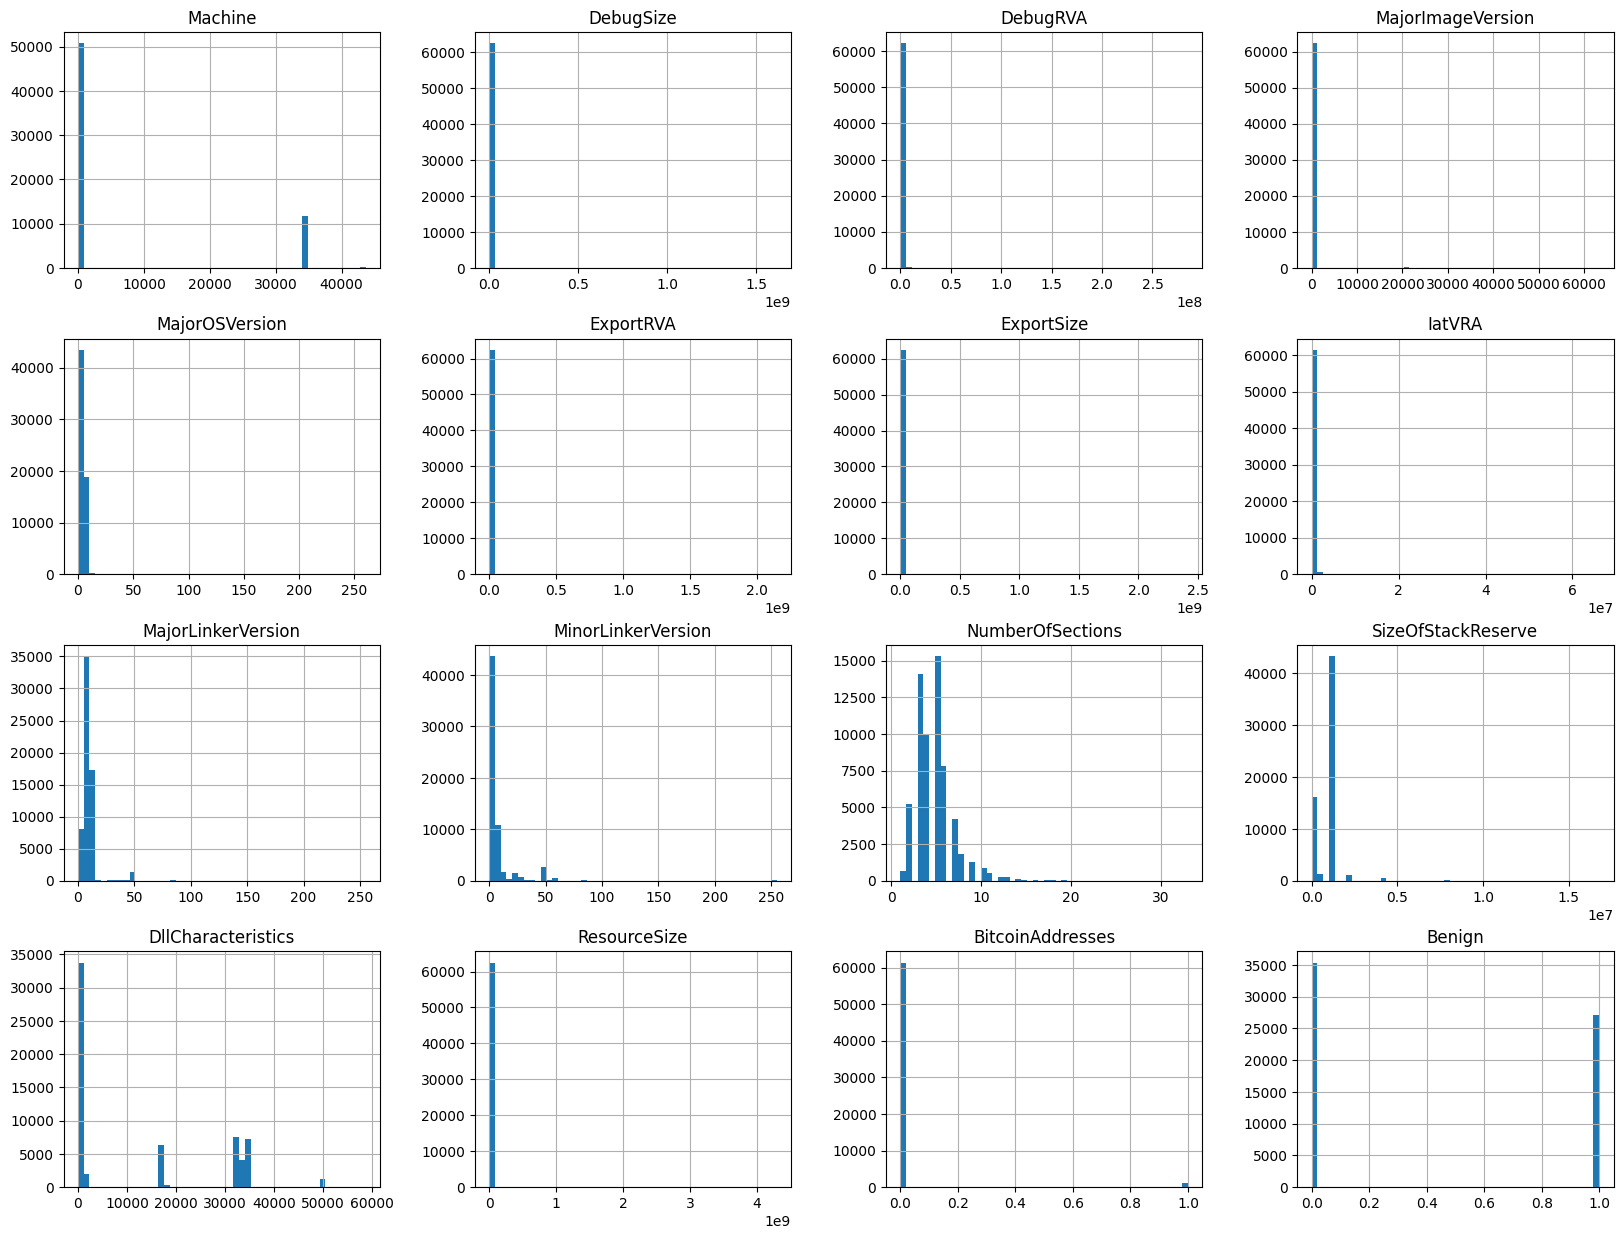

In [7]:
#Lets plot!

df.hist(bins=50, figsize=(20,15))

- The goal here was to do some exploratory analysis of the data, as we can see, it is extremely skewed: 
    - A lof of values are very close to 0 while others are very large
    - Some columns with tall spikes look more like they take on only a handful of distinct values, not continuous ranges (e.g., Machine, DllCharacteristics).
    - Target column *benign* only take 2 values(1 or 0), is considered categorical. 
        - This column will be excluded from the feature matrix(X)
- Based on the information extracted from the analysis we can decide what action will be taken to normalize each column

## Preprocessing:
| **Column**             | **Characteristic**                               | **Preprocessing**                                      |
|------------------------|---------------------------------------------------|--------------------------------------------------------|
| FileName               | Identifier - Irrelevant for Model                | Merge to create id                                     |
| md5Hash                | Identifier - Irrelevant for Model                | Merge to create id                                     |
| Machine                | CPU architecture code (x86, x64, ARM)            | One-hot encode (Map to categories)                     |
| MajorImageVersion      | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MajorOSVersion         | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MajorLinkerVersion     | Small integer (ordinal)                          | Keep numeric, scale                                    |
| MinorLinkerVersion     | Small integer (ordinal)                          | Keep numeric, scale                                    |
| NumberOfSections       | Count of sections in PE file                     | Keep numeric, scale if needed                          |
| DebugSize              | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| DebugRVA               | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ExportRVA              | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ExportSize             | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| IatVRA                 | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| ResourceSize           | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| SizeOfStackReserve     | Continuous numeric (Skewed)                      | Log transform + scale                                  |
| DllCharacteristics     | Bitmask of flags (e.g. DEP, ASLR)               | Expand into binary flags (one column per bit)          |
| BitcoinAddresses       | Binary (0/1)                                     | Keep as is                                             |
| Benign                 | Target label (benign vs malware)                | Target                                                 |


In [8]:
#preprocessing machine

df["Machine"].value_counts()

Machine
332      50624
34404    11685
452         98
43620       76
0            1
870          1
Name: count, dtype: int64

### Let's start with **machine**
    - This column has labels describing the CPU architecture(332, 34404), which map to x86, x64, ARM etc
    
| **Code** | **Count** | **Architecture**        | **Meaning / Status**                               |
|----------|-----------|--------------------------|-----------------------------------------------------|
| 332      | 50,624    | **x86**                  | Normal, common, keep                                |
| 34404    | 11,685    | **x64** (AMD64)          | Normal, common, keep                                |
| 452      | 98        | **ARMNT** (ARM Thumb)    | Rare but valid, consider keeping                    |
| 43620    | 76        | **ARM64**                | Rare but valid, 64-bit ARM                          |
| 0        | 1         | **Trash**              | Invalid -> placeholder, dropped or flagged -> drop           |
| 870      | 1         | **Unrecognized**       | Weird -> Possibly corrupted, drop             |

- Will use this information to map the numerical values to their proper labels and One-Hot Encode


In [9]:
df.dtypes

FileName              object
md5Hash               object
Machine                int64
DebugSize              int64
DebugRVA               int64
MajorImageVersion      int64
MajorOSVersion         int64
ExportRVA              int64
ExportSize             int64
IatVRA                 int64
MajorLinkerVersion     int64
MinorLinkerVersion     int64
NumberOfSections       int64
SizeOfStackReserve     int64
DllCharacteristics     int64
ResourceSize           int64
BitcoinAddresses       int64
Benign                 int64
dtype: object

    """
    Preprocess ransomware dataset:
    - Clean invalid Machine codes
    - Map Machine to string labels
    - One-hot encode categorical features
    - Save identifiers separately (FileName, md5Hash)
    - Drop identifiers from training set
    """

In [10]:
 # --- Machine ---
df = df[~df['Machine'].isin([0, 870])].copy()  # drop invalid options
    
#map raw codes to string labels
machine_map = {
        332: 'x86',
        34404: 'x64',
        452: 'ARM',
        43620: 'ARM64'
}
#map string to 0-1 labels
df['Machine'] = df['Machine'].map(machine_map)
df = pd.get_dummies(df, columns=['Machine'], prefix='Machine')
    
# --- Identifiers ---
meta = df[['FileName', 'md5Hash']].copy()
df = df.drop(columns=['FileName', 'md5Hash'])



**Creating our train/test data**

In [11]:
# -- split train-test data --
from sklearn.model_selection import train_test_split


X = df.drop(columns=['Benign']) #train
y = df['Benign'] #target

#stratify handles class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

#------- Random Forest -------


In [12]:
 #Randomized search will sample random integers in the range given for the best  parameters 


param_dist = {'n_estimators': sp_randint(200, 1000),
    'max_depth': sp_randint(10, 60),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}


#instance of Random forest model 
rf = RandomForestClassifier(random_state=42)

#Randomized search will sample random integers in the range given for the best  parameters 
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # number of random combinations to try
    cv=5,                    # 5-fold cross-validation
    scoring='f1_weighted',            # balances precision and recall
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)

#Based on randomized search -> best parameters:
rf_best = rf_random.best_estimator_ #trained model instance
y_pred = rf_best.predict(X_test)

print(rf_random.best_params_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.8s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.9s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   5.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   6.1s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.4s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.6s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=  15.8s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total time=  12.2s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total tim

#----- XGBoost -----#


In [13]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # suppresses warning
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
cross_val_score(xgb, X, y, cv=5, scoring='f1')
#evaluate
print(classification_report(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:40:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:40:34] WARN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14146
           1       1.00      0.99      1.00     10848

    accuracy                           1.00     24994
   macro avg       1.00      1.00      1.00     24994
weighted avg       1.00      1.00      1.00     24994



In [14]:
#------ SVM -------

#preprocess
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, svm_model.predict(X_test_scaled)))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97     14146
           1       0.96      0.95      0.96     10848

    accuracy                           0.96     24994
   macro avg       0.96      0.96      0.96     24994
weighted avg       0.96      0.96      0.96     24994

